## History LDA Model Visualizationa and Analysis
This notebook looks exclusively at discharge notes and the history section within them

In [1]:
#import necessary packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import re
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from datetime import datetime
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import necessary packages for further word processing
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2020)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /global/homes/d/dsmorrow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#function to perform lemmatize and stem preprocessing steps on the data set.
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
full_proc = pd.read_csv("Full_Table_ICD9_Notes.csv", usecols=["CATEGORY",'text_processed'])
full_proc

,CATEGORY,text_processed
0,Discharge summary,admission date 2142 5 15 discharge date 2142 5...
1,Discharge summary,admission date 2142 5 20 discharge date 2142 6...
2,Discharge summary,admission date 2142 6 18 discharge date 2142 6...
3,Discharge summary,admission date 2142 7 3 discharge date 2142 7 ...
4,Discharge summary,admission date 2142 7 7 discharge date 2142 7 ...
...,...,...
323055,Radiology,last name lf first name3 lf 1046 j last name ...
323056,Radiology,2143 9 3 9 59 am chest pa lat clip clip numbe...
323057,Radiology,2144 2 25 1 49 pm ankle ap mortise lat left c...
323058,Radiology,2144 1 7 4 21 pm ankle ap mortise lat left cl...


In [5]:
#select only for discharge summary so we can look exclusively at history
full_proc = full_proc.loc[full_proc['CATEGORY'] == 'Discharge summary']

In [6]:
#select for all the history section in the notes
full_proc['history'] = full_proc["text_processed"].apply(lambda st: st[st.find("history of present illness")+len("history of present illness"):st.find("physical exam")])

In [7]:
full_proc.head()

,CATEGORY,text_processed,history
0,Discharge summary,admission date 2142 5 15 discharge date 2142 5...,24 year old female with sle esrd on hd hx mal...
1,Discharge summary,admission date 2142 5 20 discharge date 2142 6...,ms known lastname is a 24 yo f with lupus sin...
2,Discharge summary,admission date 2142 6 18 discharge date 2142 6...,please see micu note for full details in brie...
3,Discharge summary,admission date 2142 7 3 discharge date 2142 7 ...,24f h o sle esrd on hd h o malignant htn svc ...
4,Discharge summary,admission date 2142 7 7 discharge date 2142 7 ...,24f h o sle esrd on hd h o malignant htn svc ...


In [8]:
#remove the sub headers in the history section
full_proc['WO_Headers'] = full_proc["history"].map(lambda x: re.sub('family history', '', x))
full_proc['WO_Headers'] = full_proc["WO_Headers"].map(lambda x: re.sub('social history', '', x))
full_proc['WO_Headers'] = full_proc["WO_Headers"].map(lambda x: re.sub('past medical history', '', x))

In [9]:
full_proc.head()

,CATEGORY,text_processed,history,WO_Headers
0,Discharge summary,admission date 2142 5 15 discharge date 2142 5...,24 year old female with sle esrd on hd hx mal...,24 year old female with sle esrd on hd hx mal...
1,Discharge summary,admission date 2142 5 20 discharge date 2142 6...,ms known lastname is a 24 yo f with lupus sin...,ms known lastname is a 24 yo f with lupus sin...
2,Discharge summary,admission date 2142 6 18 discharge date 2142 6...,please see micu note for full details in brie...,please see micu note for full details in brie...
3,Discharge summary,admission date 2142 7 3 discharge date 2142 7 ...,24f h o sle esrd on hd h o malignant htn svc ...,24f h o sle esrd on hd h o malignant htn svc ...
4,Discharge summary,admission date 2142 7 7 discharge date 2142 7 ...,24f h o sle esrd on hd h o malignant htn svc ...,24f h o sle esrd on hd h o malignant htn svc ...


In [12]:
#full_proc.to_csv('History_Notes.csv')

In [10]:
doc_group1 = full_proc

In [11]:
doc_group1 = doc_group1.drop_duplicates()

In [12]:
#use preprocess function on the history section of the notes without headers included
processed_docs = doc_group1['WO_Headers'].map(preprocess)
processed_docs

0         [year, old, femal, sle, esrd, malign, htn, svc...
1         [know, lastnam, lupu, age, esrd, malign, htn, ...
2         [micu, note, detail, brief, woman, sle, esrd, ...
3         [sle, esrd, malign, htn, svc, syndrom, pre, pr...
4         [sle, esrd, malign, htn, svc, syndrom, pre, pr...
                                ...                        
322904    [year, old, gentleman, histori, mitral, valv, ...
322923    [present, elect, angiogram, coil, mca, aneurys...
322927    [year, old, femal, larg, ascend, aortic, aneur...
322946    [year, old, femal, transfer, osh, splenic, rup...
322951    [patient, restrain, motor, vehicl, accid, head...
Name: WO_Headers, Length: 10595, dtype: object

In [13]:
#create dictionary of words
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomin
1 abus
2 accid
3 admit
4 age
5 agre
6 amp
7 anemia
8 antibodi
9 anticardiolipin
10 anticoagul


In [14]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [15]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus

In [16]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(sorted(doc, key = lambda x: x[1]))
    break

[(125, 0.015440913817156923),
 (112, 0.016245721256425198),
 (60, 0.01684165992492279),
 (90, 0.018150212034342566),
 (51, 0.01845667306692675),
 (84, 0.01884524715845518),
 (56, 0.01903505948379088),
 (144, 0.019914740723822856),
 (155, 0.02058494514850608),
 (98, 0.02125100865092021),
 (103, 0.0225017326688176),
 (0, 0.023502975015807052),
 (74, 0.023687152591543643),
 (31, 0.024142516767198356),
 (23, 0.02661017352595852),
 (105, 0.026933885327617486),
 (137, 0.027366385774449897),
 (163, 0.028059984758881867),
 (159, 0.03096026208065787),
 (15, 0.031138357596716397),
 (131, 0.03203465782784076),
 (4, 0.032963120904684194),
 (55, 0.03325920484750338),
 (1, 0.03364063433480621),
 (18, 0.034457624881595726),
 (80, 0.03447874661007037),
 (32, 0.03452105695499944),
 (156, 0.03510116389280559),
 (101, 0.035564259174419244),
 (82, 0.03567611503649574),
 (154, 0.03621629174623185),
 (122, 0.03640349281922765),
 (133, 0.0364654163108717),
 (140, 0.03712967415660835),
 (73, 0.037237723737942

In [17]:
#top ten weighted words
print(dictionary[152] ,"," + dictionary[146] ,"," + dictionary[36] ,"," + dictionary[8] ,"," + dictionary[94] ,"," + dictionary[81] ,"," + dictionary[96],"," + dictionary[14],"," + dictionary[88],"," + dictionary[109])

thrombot ,svc ,dialysi ,antibodi ,lupu ,inabl ,malign ,bacteremia ,intracerebr ,nicardipin


In [18]:
#train LDA model using BOW, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [19]:
# Print the Keywords in the 20 topics using the BOW corpus
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.011*"give" + 0.010*"chronic" + 0.009*"note" + 0.009*"recent" + '
  '0.008*"home" + 0.007*"initi" + 0.007*"copd" + 0.006*"transfer" + '
  '0.006*"prior" + 0.006*"rehab"'),
 (1,
  '0.012*"give" + 0.010*"insulin" + 0.010*"show" + 0.009*"transfer" + '
  '0.009*"initi" + 0.009*"start" + 0.008*"blood" + 0.008*"wbc" + 0.007*"lab" + '
  '0.006*"neg"'),
 (2,
  '0.049*"date" + 0.047*"discharg" + 0.026*"namepattern" + 0.022*"servic" + '
  '0.021*"allergi" + 0.018*"know" + 0.018*"admiss" + 0.017*"number" + '
  '0.016*"unit" + 0.015*"birth"'),
 (3,
  '0.017*"seizur" + 0.016*"leav" + 0.013*"right" + 0.009*"fractur" + '
  '0.008*"transfer" + 0.007*"head" + 0.007*"note" + 0.006*"intub" + '
  '0.006*"mri" + 0.006*"osh"'),
 (4,
  '0.015*"cardiac" + 0.012*"chest" + 0.010*"review" + 0.009*"system" + '
  '0.009*"prior" + 0.009*"cabg" + 0.007*"lad" + 0.007*"cad" + 0.007*"recent" + '
  '0.007*"dyspnea"'),
 (5,
  '0.017*"leav" + 0.012*"report" + 0.012*"weak" + 0.010*"headach" + '
  '0.008*"right" + 

In [20]:
#create function to create end up with dataframe that includes, the document index, the dominant topic for that document based on the trained LDA model, The percentage of matching, the top weighted words for that topic, and the text of the document
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Document_No'] = np.arange(1, len(df_dominant_topic) + 1)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,13.0,0.7183,"blood, bleed, hct, unit, recent, hypertens, re...","[year, old, femal, sle, esrd, malign, htn, svc..."
1,2,13.0,0.6398,"blood, bleed, hct, unit, recent, hypertens, re...","[know, lastnam, lupu, age, esrd, malign, htn, ..."
2,3,13.0,0.7582,"blood, bleed, hct, unit, recent, hypertens, re...","[micu, note, detail, brief, woman, sle, esrd, ..."
3,4,13.0,0.6779,"blood, bleed, hct, unit, recent, hypertens, re...","[sle, esrd, malign, htn, svc, syndrom, pre, pr..."
4,5,10.0,0.5822,"tablet, sig, daili, discharg, medic, time, blo...","[sle, esrd, malign, htn, svc, syndrom, pre, pr..."
5,6,13.0,0.5521,"blood, bleed, hct, unit, recent, hypertens, re...","[know, lastnam, year, old, femal, histori, sle..."
6,7,13.0,0.6015,"blood, bleed, hct, unit, recent, hypertens, re...","[know, lastnam, year, old, femal, histori, sle..."
7,8,13.0,0.5033,"blood, bleed, hct, unit, recent, hypertens, re...","[sle, age, esrd, malign, htn, pre, admit, htn,..."
8,9,13.0,0.4787,"blood, bleed, hct, unit, recent, hypertens, re...","[know, lastnam, lupu, chronic, kidney, diseas,..."
9,10,13.0,0.4966,"blood, bleed, hct, unit, recent, hypertens, re...","[woman, sle, ckd, current, labil, htn, right, ..."


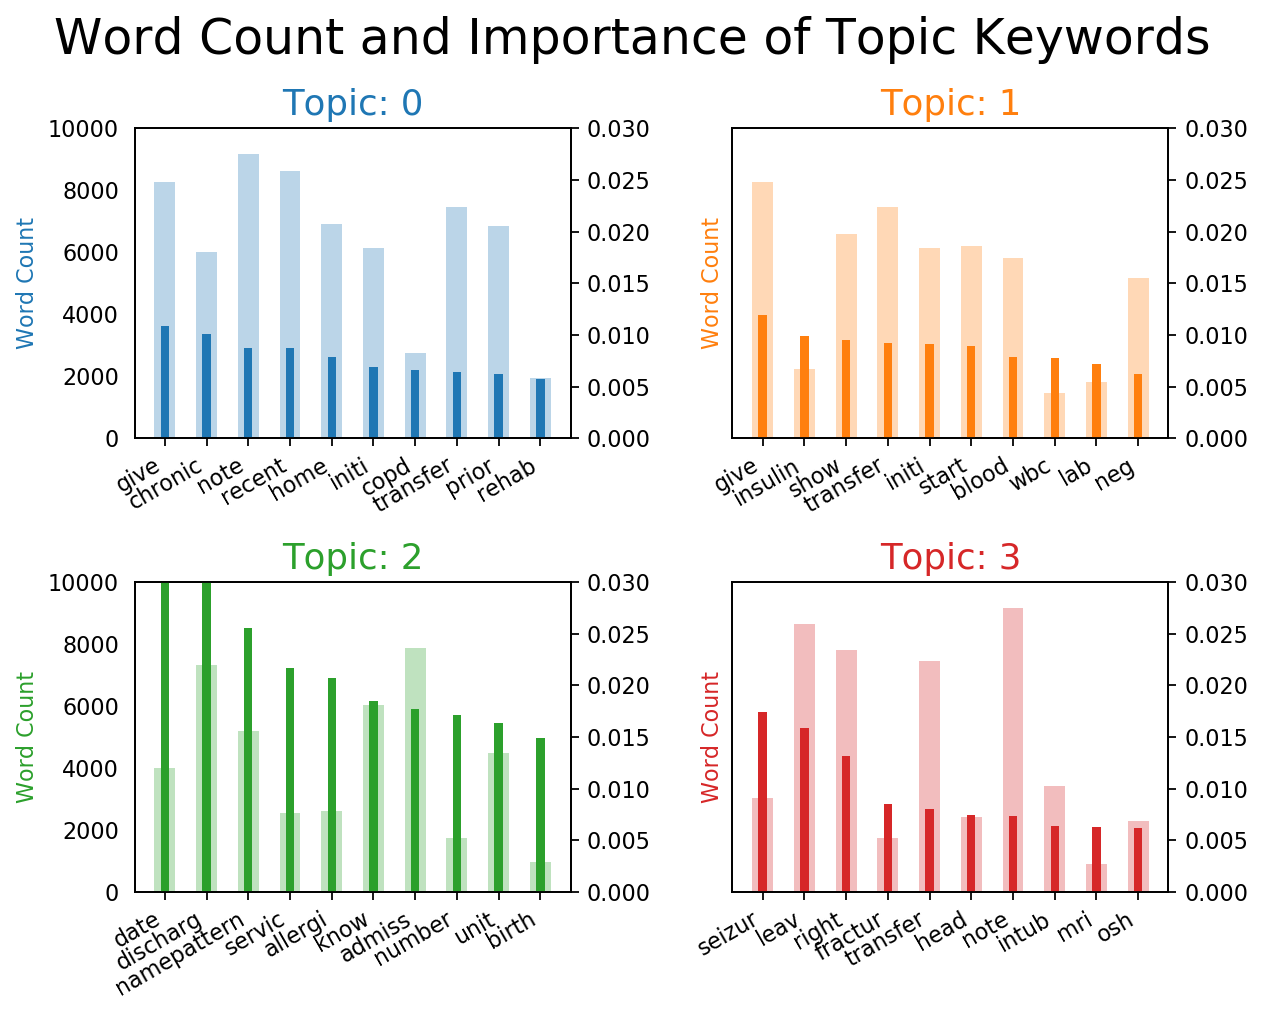

In [22]:
#create funcs and visualization for word count and weight of top words for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [23]:
#sorted and appending topics and percentages of the LDA topics
def topics_per_document(model, corpus):
    corpus_sel = corpus[0:-1]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(lda_model, bow_corpus)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

In [24]:
#each topics and the weights of each document
topic_weightage_by_doc

,1,3,12,13,2,11,18,4,5,10,14,7,0,17,6,8,9,16,15,19
0,0.060196,0.037149,0.170323,0.728556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.030538,0.075038,0.639542,0.016765,0.161502,0.073732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.026628,0.096988,0.751006,NaN,0.121970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.183935,0.677885,NaN,NaN,NaN,0.105716,0.028738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.054355,NaN,0.051879,0.299971,NaN,NaN,NaN,NaN,NaN,0.582215,0.010455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991737,NaN,NaN,NaN,NaN
10590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982725,NaN,NaN,NaN,NaN,NaN
10591,NaN,0.232736,NaN,NaN,NaN,NaN,0.717258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986427,NaN,NaN,NaN,NaN,NaN


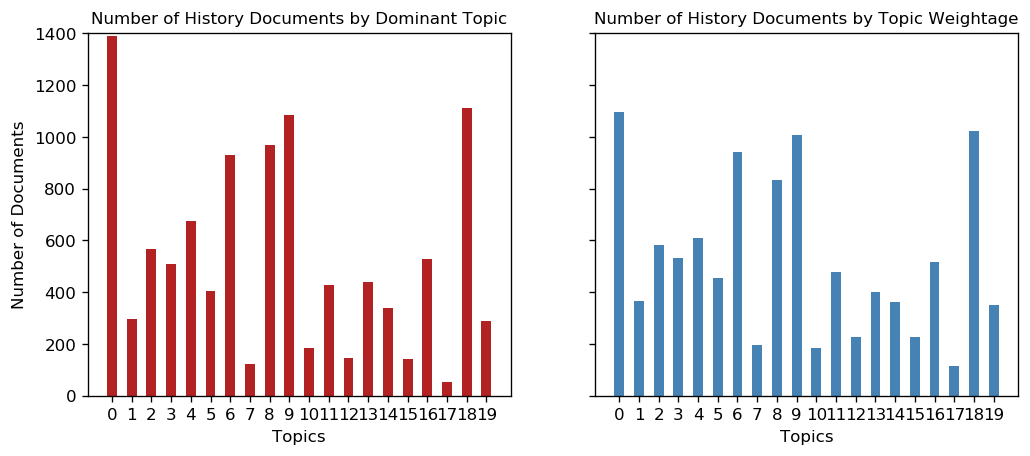

In [25]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.set_title('Number of History Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1400)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_title('Number of History Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [29]:
# Visualize the topics and words
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
#vis

In [26]:
#train LDA model using TFIDF corpus, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model_tf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [27]:
# Print the Keywords in the 20 topics using the BOW corpus
pprint(lda_model_tf.print_topics())
doc_lda_tf = lda_model_tf[corpus_tfidf]

[(0,
  '0.008*"spous" + 0.006*"jehovah" + 0.005*"valvuloplasti" + 0.005*"easi" + '
  '0.005*"polymyalgia" + 0.005*"rheumatica" + 0.005*"adamantli" + '
  '0.005*"atroph" + 0.005*"parasthesia" + 0.005*"torsemid"'),
 (1,
  '0.006*"suicid" + 0.006*"abus" + 0.005*"withdraw" + 0.004*"drink" + '
  '0.004*"insulin" + 0.004*"ercp" + 0.004*"cholang" + 0.004*"heroin" + '
  '0.004*"attempt" + 0.003*"vodka"'),
 (2,
  '0.042*"date" + 0.026*"discharg" + 0.023*"addendum" + 0.020*"sex" + '
  '0.020*"birth" + 0.020*"attend" + 0.019*"disposit" + 0.019*"allergi" + '
  '0.019*"number" + 0.019*"numer"'),
 (3,
  '0.016*"flail" + 0.011*"hypokinet" + 0.007*"town" + 0.006*"depth" + '
  '0.006*"mvp" + 0.004*"propranolol" + 0.004*"wegen" + 0.002*"granulomatosi" + '
  '0.002*"palat" + 0.002*"foci"'),
 (4,
  '0.010*"mca" + 0.010*"svg" + 0.009*"ntg" + 0.007*"clip" + 0.007*"suboxon" + '
  '0.005*"aicd" + 0.005*"ischem" + 0.005*"aneurysm" + 0.005*"occlud" + '
  '0.005*"vessel"'),
 (5,
  '0.002*"applic" + 0.002*"clozap

In [28]:
#using previous function to run with tf_idf lda model
df_topic_sents_keywords_tf = format_topics_sentences(ldamodel=lda_model_tf, corpus=corpus_tfidf, texts=processed_docs)

# Format
df_dominant_topic_tf = df_topic_sents_keywords_tf.reset_index()
df_dominant_topic_tf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_tf['Document_No'] = np.arange(1, len(df_dominant_topic_tf) + 1)

In [29]:
dominant_topics_tf, topic_percentages_tf = topics_per_document(lda_model_tf, corpus_tfidf)            

# Distribution of Dominant Topics in Each Document
df_tf = pd.DataFrame(dominant_topics_tf, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_tf = df_tf.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_tf = dominant_topic_in_each_doc_tf.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_tf = pd.DataFrame([dict(t) for t in topic_percentages_tf])
df_topic_weightage_by_doc_tf = topic_weightage_by_doc_tf.sum().to_frame(name='count').reset_index()

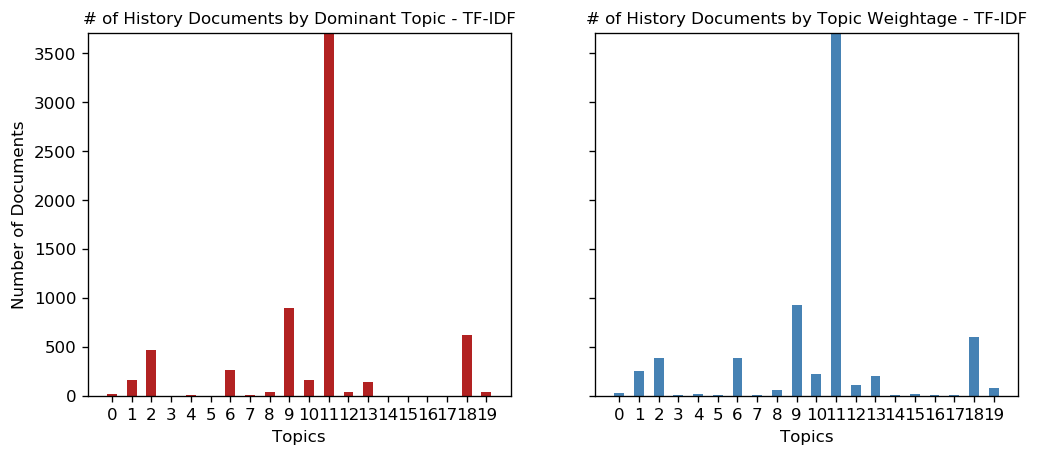

In [30]:
#numbers are based off TF-IDF 
#topic weightage is the sum of all documents that have a weight for that topic

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_tf, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents by Dominant Topic - TF-IDF', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 3700)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_tf, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_tf.index.unique().__len__()))
ax2.set_title('# of History Documents by Topic Weightage - TF-IDF', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [31]:
#--------------------------------------------------------------------------------------------------------------------------------
## validation using diabetes subjects

In [32]:
diagnosis_icd9 = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/DIAGNOSES_ICD.csv", usecols= ["SUBJECT_ID", "ICD9_CODE"])
patients = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/PATIENTS.csv", parse_dates= ["DOB"], date_parser=dateparse, usecols=["SUBJECT_ID", "DOB"])
admissions = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/ADMISSIONS.csv", parse_dates= ["ADMITTIME"], date_parser=dateparse, usecols=["SUBJECT_ID", "ADMITTIME"])
notes = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/NOTEEVENTS.csv", usecols = ['SUBJECT_ID','CATEGORY', 'TEXT'])

In [33]:
#filter for only diabetes ICD9 codes
diag_d_DF = diagnosis_icd9[diagnosis_icd9["ICD9_CODE"].str.startswith(('250', '249', '648', 'E08', 'E09', 'E10', 'E11', 'E13'), na = False)]
diag_d_DF.head()

,SUBJECT_ID,ICD9_CODE
71,117,25000
91,117,25000
113,123,25000
206,130,25000
214,130,25060


In [34]:
#merge diabetes dataframe with notes
icd9_d_notes = pd.merge(diag_d_DF, notes, on ='SUBJECT_ID')
icd9_d_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT
0,117,25000,Discharge summary,Admission Date: [**2133-4-7**] Discharge ...
1,117,25000,Discharge summary,Admission Date: [**2133-11-13**] ...
2,117,25000,Echo,PATIENT/TEST INFORMATION:\nIndication: Murmur....
3,117,25000,Echo,PATIENT/TEST INFORMATION:\nIndication: Left ve...
4,117,25000,ECG,Atrial fibrillation with uncontrolled ventricu...
...,...,...,...,...
1587475,97488,25000,Radiology,[**2128-8-31**] 1:25 PM\n CHEST PORT. LINE PLA...
1587476,97488,25000,Radiology,[**2128-9-2**] 4:01 AM\n CHEST (PORTABLE AP) ...
1587477,97488,25000,Radiology,[**2128-9-4**] 5:36 AM\n CHEST (PORTABLE AP) ...
1587478,97488,25000,Radiology,[**2128-9-3**] 3:23 AM\n CHEST (PORTABLE AP) ...


In [35]:
#select only for discharge summary
icd9_d_notes2 = icd9_d_notes.loc[icd9_d_notes['CATEGORY'] == 'Discharge summary']

In [36]:
icd9_db_notes = icd9_d_notes2.drop_duplicates(subset='TEXT', keep='first')
icd9_db_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT
0,117,25000,Discharge summary,Admission Date: [**2133-4-7**] Discharge ...
1,117,25000,Discharge summary,Admission Date: [**2133-11-13**] ...
212,123,25000,Discharge summary,Admission Date: [**2161-10-29**] Discharg...
232,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...
233,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...
...,...,...,...,...
1587064,96908,25060,Discharge summary,Admission Date: [**2145-2-2**] D...
1587065,96908,25060,Discharge summary,Admission Date: [**2145-9-4**] D...
1587379,97144,25000,Discharge summary,Admission Date: [**2187-2-7**] D...
1587420,97488,25062,Discharge summary,Admission Date: [**2128-4-8**] D...


In [37]:
# Remove punctuation and anything that isnt a character or number 
icd9_db_notes['text_processed'] = icd9_db_notes['TEXT'].map(lambda x: re.sub('[_\\W]+', ' ', x))
#remove numbers
icd9_db_notes['text_processed'] = icd9_db_notes['text_processed'].map(lambda x: re.sub('(\\s\\d+)', ' ', x))
# Convert to lowercase
icd9_db_notes['text_processed'] = icd9_db_notes['text_processed'].map(lambda x: x.lower())

In [38]:
#select for all the history section in the notes
icd9_db_notes['history'] = icd9_db_notes["text_processed"].apply(lambda st: st[st.find("history of present illness")+len("history of present illness"):st.find("physical exam")])

In [39]:
#remove the sub headers in the history section to ensure not weighted 
icd9_db_notes['WO_Headers'] = icd9_db_notes["history"].map(lambda x: re.sub('family history', '', x))
icd9_db_notes['WO_Headers'] = icd9_db_notes["WO_Headers"].map(lambda x: re.sub('social history', '', x))
icd9_db_notes['WO_Headers'] = icd9_db_notes["WO_Headers"].map(lambda x: re.sub('past medical history', '', x))

In [40]:
#adding additional index column for calling
index = tuple(range(0, 17384, 1))
icd9_db_notes["index"] = index

In [41]:
# Print out the first rows of papers to ensure re working properly
icd9_db_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,text_processed,history,WO_Headers,index
0,117,25000,Discharge summary,Admission Date: [**2133-4-7**] Discharge ...,admission date discharge date date of bi...,the patient is a year old woman with a histo...,the patient is a year old woman with a histo...,0
1,117,25000,Discharge summary,Admission Date: [**2133-11-13**] ...,admission date discharge date date of bi...,f pmh esld hep c esophageal varices history...,f pmh esld hep c esophageal varices history...,1
212,123,25000,Discharge summary,Admission Date: [**2161-10-29**] Discharg...,admission date discharge date date of bi...,the patient is a year old male smoker with d...,the patient is a year old male smoker with d...,2
232,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...,unit no numeric identifier admission date ...,the patient is a year old male with a histor...,the patient is a year old male with a histor...,3
233,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...,unit no numeric identifier admission date ...,father name ni is a year old man with known ...,father name ni is a year old man with known ...,4
...,...,...,...,...,...,...,...,...
1587064,96908,25060,Discharge summary,Admission Date: [**2145-2-2**] D...,admission date discharge date date of bi...,yo f with iddm h o recently treated h pylori...,yo f with iddm h o recently treated h pylori...,17379
1587065,96908,25060,Discharge summary,Admission Date: [**2145-9-4**] D...,admission date discharge date date of bi...,yo m with h o dm esrd on hd with history of ...,yo m with h o dm esrd on hd with history of ...,17380
1587379,97144,25000,Discharge summary,Admission Date: [**2187-2-7**] D...,admission date discharge date service ca...,yo f with cad s p cabg in lima to lad svg t...,yo f with cad s p cabg in lima to lad svg t...,17381
1587420,97488,25062,Discharge summary,Admission Date: [**2128-4-8**] D...,admission date discharge date date of bi...,m transferred from hospital1 location un wi...,m transferred from hospital1 location un wi...,17382


In [102]:
icd9_db_notes = icd9_db_notes.reset_index(drop=True)

In [104]:
d_documents = icd9_db_notes[['WO_Headers']]

In [105]:
d_documents['WO_Headers'].iloc[5090]

'  y o male with approximately  month h o chest pain stress test was positive underwent cardiac cath which revealed left main disease with an ef of  referred for cardiac surgery  hypercholesterolemia diabetes mellitus remote tb exposure s p hernia repair  married retired worked in restaurant former smoker quit yrs ago rare etoh  non contributory '

In [106]:
#use preprocess function 
diabetes_proc_docs = d_documents['WO_Headers'].map(preprocess)

In [116]:
diabetes_proc_docs.iloc[5090]

['male',
 'approxim',
 'month',
 'chest',
 'pain',
 'stress',
 'test',
 'posit',
 'undergo',
 'cardiac',
 'cath',
 'reveal',
 'leav',
 'main',
 'diseas',
 'refer',
 'cardiac',
 'surgeri',
 'diabet',
 'mellitu',
 'remot',
 'exposur',
 'hernia',
 'repair',
 'marri',
 'retir',
 'work',
 'restaur',
 'smoker',
 'quit',
 'yr',
 'ago',
 'rare',
 'etoh',
 'non',
 'contributori']

In [107]:
#create dictionary of words and number of appearances 
db_dictionary = gensim.corpora.Dictionary(diabetes_proc_docs)
count = 0
for k, v in db_dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abus
1 access
2 admiss
3 albuterol
4 alcohol
5 ambien
6 amenorrhea
7 ascit
8 asthma
9 attempt
10 bacteri


In [108]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
db_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [109]:
#go through each document and report words and occurrences using doc2box for token id and amount
db_bow_corpus = [db_dictionary.doc2bow(doc) for doc in diabetes_proc_docs]

In [110]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
d_tfidf = models.TfidfModel(db_bow_corpus)
d_corpus_tfidf = d_tfidf[db_bow_corpus]

In [111]:
## determine which topic a certain document belongs to
#150 is a sample index from the diseases of dispair group
for index, score in sorted(lda_model[bow_corpus[150]], key=lambda tup: -1*tup[1]):
    print("Score: {}\t \nTopic: {} ".format(score, lda_model.print_topic(index, 10)))

Score: 0.40015360713005066	 
Topic: 0.013*"give" + 0.009*"intub" + 0.008*"note" + 0.008*"etoh" + 0.007*"start" + 0.007*"home" + 0.007*"receiv" + 0.007*"transfer" + 0.007*"initi" + 0.006*"use" 
Score: 0.3130163252353668	 
Topic: 0.011*"abdomin" + 0.011*"fever" + 0.010*"recent" + 0.009*"chest" + 0.009*"cough" + 0.008*"report" + 0.008*"nausea" + 0.008*"vomit" + 0.007*"diarrhea" + 0.007*"chill" 
Score: 0.1781514585018158	 
Topic: 0.021*"leav" + 0.019*"right" + 0.016*"cell" + 0.012*"cycl" + 0.011*"carcinoma" + 0.010*"cancer" + 0.010*"renal" + 0.010*"mass" + 0.009*"show" + 0.008*"lesion" 
Score: 0.08431839197874069	 
Topic: 0.015*"cardiac" + 0.012*"chest" + 0.010*"review" + 0.009*"system" + 0.009*"prior" + 0.009*"cabg" + 0.007*"lad" + 0.007*"cad" + 0.007*"recent" + 0.007*"dyspnea" 
Score: 0.01896066777408123	 
Topic: 0.012*"right" + 0.012*"undergo" + 0.011*"melanoma" + 0.010*"show" + 0.010*"lung" + 0.008*"effus" + 0.008*"small" + 0.007*"lobe" + 0.007*"biopsi" + 0.007*"leav" 


In [112]:
## determine which topic a certain document belongs to
#200 is a sample index from the diabetes group
for index, score in sorted(lda_model[db_bow_corpus[200]], key=lambda tup: -1*tup[1]):
    print("Score: {}\t \nTopic: {} ".format(score, lda_model.print_topic(index, 10)))

Score: 0.2563972473144531	 
Topic: 0.008*"note" + 0.006*"home" + 0.006*"recent" + 0.006*"initi" + 0.005*"weight" + 0.005*"month" + 0.005*"admit" + 0.005*"admiss" + 0.005*"week" + 0.005*"cancer" 
Score: 0.16472439467906952	 
Topic: 0.012*"report" + 0.011*"abus" + 0.009*"alcohol" + 0.009*"give" + 0.009*"drink" + 0.008*"prior" + 0.008*"depress" + 0.008*"transfer" + 0.008*"etoh" + 0.007*"note" 
Score: 0.14042945206165314	 
Topic: 0.011*"cancer" + 0.008*"right" + 0.007*"ago" + 0.007*"leav" + 0.007*"surgeri" + 0.006*"etoh" + 0.006*"smoke" + 0.006*"abdomin" + 0.005*"die" + 0.005*"use" 
Score: 0.1206531897187233	 
Topic: 0.011*"give" + 0.010*"chronic" + 0.009*"note" + 0.009*"recent" + 0.008*"home" + 0.007*"initi" + 0.007*"copd" + 0.006*"transfer" + 0.006*"prior" + 0.006*"rehab" 
Score: 0.10304027795791626	 
Topic: 0.050*"tablet" + 0.027*"sig" + 0.026*"daili" + 0.016*"discharg" + 0.013*"medic" + 0.012*"time" + 0.011*"blood" + 0.011*"refil" + 0.011*"need" + 0.010*"disp" 
Score: 0.080090753734111

In [113]:
#using previous function to run with lda model
df_topic_sents_keywords_dtf = format_topics_sentences(ldamodel=lda_model_tf, corpus= d_corpus_tfidf, texts=diabetes_proc_docs)

# Format
df_dominant_topic_dtf = df_topic_sents_keywords_dtf.reset_index()
df_dominant_topic_dtf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_dtf['Document_No'] = np.arange(1, len(df_dominant_topic_dtf) + 1)
df_dominant_topic_dtf.head(10)

IndexError: index 5090 is out of bounds for axis 1 with size 5090

In [179]:
#using previous function to run with lda model
df_topic_sents_keywords_d = format_topics_sentences(ldamodel=lda_model, corpus= db_bow_corpus , texts=diabetes_proc_docs)

# Format
df_dominant_topic_d = df_topic_sents_keywords_d.reset_index()
df_dominant_topic_d.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_d['Document_No'] = np.arange(1, len(df_dominant_topic_d) + 1)
df_dominant_topic_d.head(10)

IndexError: index 5090 is out of bounds for axis 1 with size 5090

In [115]:
#sorted and appending topics and percentages of the LDA topics for diabetes 
dominant_topics_d, topic_percentages_d = topics_per_document(lda_model, db_bow_corpus)            

# Distribution of Dominant Topics in Each Document
df_d = pd.DataFrame(dominant_topics_d, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_d = df_d.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_d = dominant_topic_in_each_doc_d.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_d = pd.DataFrame([dict(t) for t in topic_percentages_d])
df_topic_weightage_by_doc_d = topic_weightage_by_doc_d.sum().to_frame(name='count').reset_index()

IndexError: index 5090 is out of bounds for axis 1 with size 5090

In [271]:
df_dominant_topic_d.groupby('Dominant_Topic').size()

Dominant_Topic
1.0       2
4.0       1
5.0       1
8.0       8
9.0       5
10.0      3
11.0     17
12.0      4
13.0    185
14.0      3
18.0      6
dtype: int64

In [272]:
#what is the min and max probability for matching a topic?
df_dominant_topic_d['Topic_Perc_Contrib'].describe()

count    235.000000
mean       0.447990
std        0.140476
min        0.182300
25%        0.348550
50%        0.416100
75%        0.517250
max        0.966100
Name: Topic_Perc_Contrib, dtype: float64

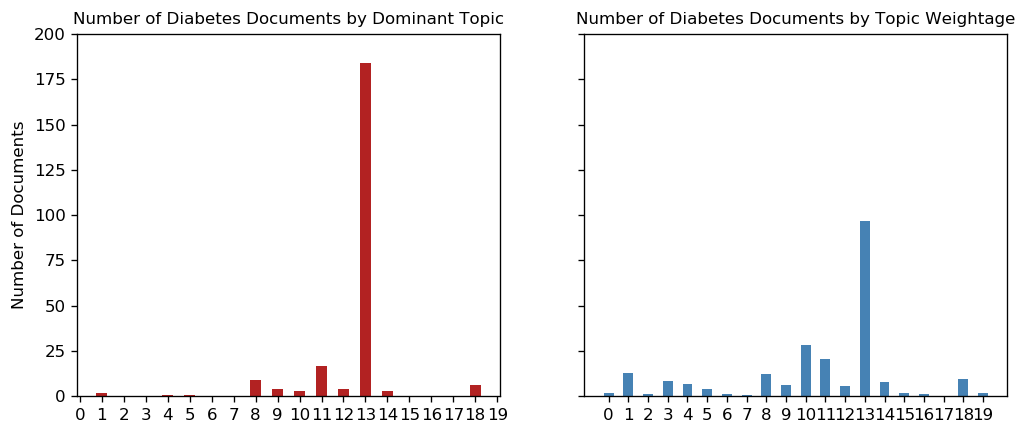

In [273]:
#topic weightage is the sum of all documents that have a weight for that topic
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

tick_formatter_d = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[1])

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_d, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Diabetes Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_d, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('Number of Diabetes Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [274]:
# subject 97842 of diabetes group 
diabetes_97842 = icd9_db_notes.loc[icd9_db_notes['SUBJECT_ID'] == 97842]

In [275]:
diabetes_97842 = diabetes_97842.reset_index()

In [276]:
#use preprocess function on subjects documents
processed_97842 = diabetes_97842['text_processed'].map(preprocess)

In [277]:
#create dictionary of words
dictionary_97842 = gensim.corpora.Dictionary(processed_97842)

In [278]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_97842 = [dictionary_97842.doc2bow(doc) for doc in processed_97842]

In [342]:
df_topic_sents_keywords_97842 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_97842, texts=processed_97842)

# Format
df_dominant_topic_97842 = df_topic_sents_keywords_97842.reset_index()
df_dominant_topic_97842.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_97842['Document_No'] = np.arange(1, len(df_dominant_topic_97842) + 1)
df_dominant_topic_97842.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,13.0,0.4202,"blood, bleed, hct, unit, recent, hypertens, re...","[admiss, date, discharg, date, date, birth, se..."
1,2,13.0,0.1801,"blood, bleed, hct, unit, recent, hypertens, re...","[admiss, date, discharg, date, date, birth, se..."
2,3,13.0,0.3349,"blood, bleed, hct, unit, recent, hypertens, re...","[know, lastnam, know, firstnam, unit, numer, i..."


In [280]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_97842, topic_percentages_97842 = topics_per_document(lda_model, bow_corpus_97842)            

# Distribution of Dominant Topics in Each Document
df_97842 = pd.DataFrame(dominant_topics_97842, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_97842 = df_97842.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_97842 = dominant_topic_in_each_doc_97842.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_97842 = pd.DataFrame([dict(t) for t in topic_percentages_97842])
df_topic_weightage_by_doc_97842 = topic_weightage_by_doc_97842.sum().to_frame(name='count').reset_index()

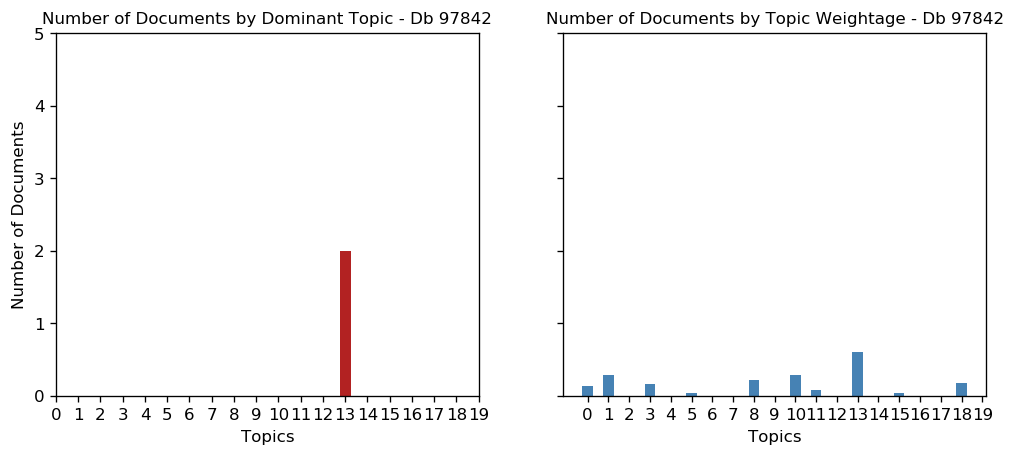

In [329]:
# Plot for subject 97842 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_97842, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - Db 97842', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 5)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_97842, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('Number of Documents by Topic Weightage - Db 97842', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [282]:
# subject 1900 of diabetes group 
diabetes_1900 = icd9_db_notes.loc[icd9_db_notes['SUBJECT_ID'] == 1900]

In [283]:
diabetes_1900 = diabetes_1900.reset_index()

In [284]:
#use preprocess function on subjects documents
processed_1900 = diabetes_1900['text_processed'].map(preprocess)

In [285]:
#create dictionary of words
dictionary_1900 = gensim.corpora.Dictionary(processed_1900)

In [286]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_1900 = [dictionary_1900.doc2bow(doc) for doc in processed_1900]

In [287]:
df_topic_sents_keywords_1900 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_1900, texts=processed_1900)

# Format
df_dominant_topic_1900 = df_topic_sents_keywords_1900.reset_index()
df_dominant_topic_1900.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_1900.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.5740,"blood, bleed, hct, unit, recent, hypertens, re...","[admiss, date, discharg, date, date, birth, se..."
1,1,13.0,0.3459,"blood, bleed, hct, unit, recent, hypertens, re...","[admiss, date, discharg, date, date, birth, se..."
2,2,18.0,0.2542,"cancer, right, ago, leav, surgeri, etoh, smoke...","[admiss, date, discharg, date, date, birth, se..."
3,3,18.0,0.2655,"cancer, right, ago, leav, surgeri, etoh, smoke...","[admiss, date, discharg, date, date, birth, se..."
4,4,18.0,0.1976,"cancer, right, ago, leav, surgeri, etoh, smoke...","[admiss, date, discharg, date, date, birth, se..."


In [288]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_1900, topic_percentages_1900 = topics_per_document(lda_model, bow_corpus_1900)            

# Distribution of Dominant Topics in Each Document
df_1900 = pd.DataFrame(dominant_topics_1900, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_1900 = df_1900.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_1900 = dominant_topic_in_each_doc_1900.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_1900 = pd.DataFrame([dict(t) for t in topic_percentages_1900])
df_topic_weightage_by_doc_1900 = topic_weightage_by_doc_1900.sum().to_frame(name='count').reset_index()

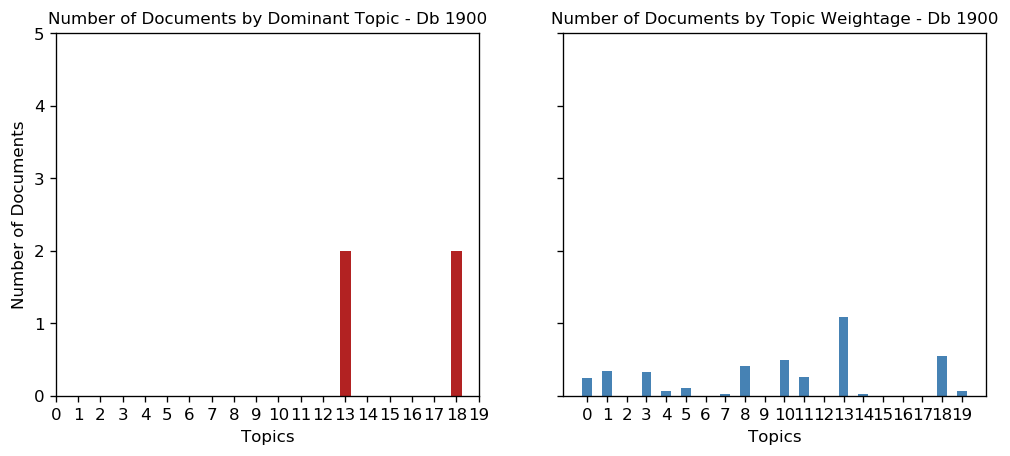

In [289]:
# Plot for subject 1900 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_1900, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - Db 1900', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 5)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_1900, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('Number of Documents by Topic Weightage - Db 1900', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

# Now lets look at Suicide Attempt Subjects and their history

In [55]:
#filter for only suicide attempts ICD9 codes
diag_suicide_DF = diagnosis_icd9[diagnosis_icd9["ICD9_CODE"].str.startswith(('E95'), na = False)]
diag_suicide_DF.head()

,SUBJECT_ID,ICD9_CODE
102,119,E956
350,71,E9503
760,22,E9502
761,22,E9503
2036,303,E9500


In [56]:
#merge suicide dataframe with notes
icd9_suicide = pd.merge(diag_suicide_DF, notes, on ='SUBJECT_ID')

In [57]:
#bring in the admittime column from separate csv
icd9_suicide = pd.merge(icd9_suicide, admissions, on="SUBJECT_ID")

In [58]:
#select only for discharge summary
icd9_suicide_notes = icd9_suicide.loc[icd9_suicide['CATEGORY'] == 'Discharge summary']

In [59]:
icd9_suicide_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME
9,71,E9503,Discharge summary,Admission Date: [**2164-2-3**] D...,2164-02-03 22:07:00
22,22,E9502,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-09 12:26:00
32,22,E9503,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-09 12:26:00
42,303,E9500,Discharge summary,Admission Date: [**2160-3-17**] Discharge...,2160-03-17 18:37:00
43,303,E9500,Discharge summary,Admission Date: [**2160-3-17**] Discharge...,2163-03-29 23:04:00
...,...,...,...,...,...
42488,98177,E9588,Discharge summary,Admission Date: [**2145-8-11**] ...,2145-08-11 02:36:00
42491,99868,E9500,Discharge summary,Admission Date: [**2142-9-7**] D...,2142-09-07 05:36:00
42494,99868,E9503,Discharge summary,Admission Date: [**2142-9-7**] D...,2142-09-07 05:36:00
42497,99868,E9509,Discharge summary,Admission Date: [**2142-9-7**] D...,2142-09-07 05:36:00


In [60]:
icd9_suicide_notes = icd9_suicide_notes.drop_duplicates(subset='TEXT', keep='first')

In [61]:
# Remove punctuation and anything that isnt a character or number 
icd9_suicide_notes['text_processed'] = icd9_suicide_notes['TEXT'].map(lambda x: re.sub('[_\\W]+', ' ', x))
#remove numbers
icd9_suicide_notes['text_processed'] = icd9_suicide_notes['text_processed'].map(lambda x: re.sub('(\\s\\d+)', ' ', x))
# Convert to lowercase
icd9_suicide_notes['text_processed'] = icd9_suicide_notes['text_processed'].map(lambda x: x.lower())

In [62]:
#select for all the history section in the notes
icd9_suicide_notes['history'] = icd9_suicide_notes["text_processed"].apply(lambda st: st[st.find("history of present illness")+len("history of present illness"):st.find("physical exam")])

In [63]:
#remove the sub headers in the history section to ensure not weighted 
icd9_suicide_notes['WO_Headers'] = icd9_suicide_notes["history"].map(lambda x: re.sub('family history', '', x))
icd9_suicide_notes['WO_Headers'] = icd9_suicide_notes["WO_Headers"].map(lambda x: re.sub('social history', '', x))
icd9_suicide_notes['WO_Headers'] = icd9_suicide_notes["WO_Headers"].map(lambda x: re.sub('past medical history', '', x))

In [64]:
#adding additional index column for calling
index = tuple(range(0, 653, 1))
icd9_suicide_notes["index"] = index

In [65]:
icd9_suicide_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME,text_processed,history,WO_Headers,index
9,71,E9503,Discharge summary,Admission Date: [**2164-2-3**] D...,2164-02-03 22:07:00,admission date discharge date date of bi...,pt is f h o schizophrenia admitted for clozap...,pt is f h o schizophrenia admitted for clozap...,0
22,22,E9502,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-09 12:26:00,admission date discharge date date of bi...,the patient is a year old female with a hist...,the patient is a year old female with a hist...,1
42,303,E9500,Discharge summary,Admission Date: [**2160-3-17**] Discharge...,2160-03-17 18:37:00,admission date discharge date date of bi...,this year old male was an unrestrained drive...,this year old male was an unrestrained drive...,2
44,303,E9500,Discharge summary,Admission Date: [**2163-3-29**] ...,2160-03-17 18:37:00,admission date discharge date date of bi...,year old male transferred from hospital1 fo...,year old male transferred from hospital1 fo...,3
102,468,E9500,Discharge summary,Admission Date: [**2136-2-24**] ...,2136-02-24 13:28:00,admission date discharge date date of bi...,this is a year old male with history of hype...,this is a year old male with history of hype...,4
...,...,...,...,...,...,...,...,...,...
42449,99293,E9504,Discharge summary,Admission Date: [**2189-7-20**] ...,2189-07-20 02:11:00,admission date discharge date date of bi...,pt is a year old male with no pmh presents w...,pt is a year old male with no pmh presents w...,648
42450,99293,E9504,Discharge summary,"Name: [**Known lastname 13245**],[**Known fir...",2189-07-20 02:11:00,name known lastname known firstname unit no n...,n firstname unit no numeric identifier admiss...,n firstname unit no numeric identifier admiss...,649
42488,98177,E9588,Discharge summary,Admission Date: [**2145-8-11**] ...,2145-08-11 02:36:00,admission date discharge date date of bi...,hpi yom with possible intoxication today poss...,hpi yom with possible intoxication today poss...,650
42491,99868,E9500,Discharge summary,Admission Date: [**2142-9-7**] D...,2142-09-07 05:36:00,admission date discharge date date of bi...,yo f with hx of depression w si on effexor n...,yo f with hx of depression w si on effexor n...,651


In [66]:
#select only for subject 303 that has attempted suicide
documents_303 = icd9_suicide_notes.loc[icd9_suicide_notes['SUBJECT_ID'] == 303]

In [67]:
#resetting index because following code for dataframe has trouble identifying text when pulling from middle of dataframe
documents_303 = documents_303.reset_index()

In [68]:
#use preprocess function on suicide attempt subjects
processed_docs_303 = documents_303['text_processed'].map(preprocess)

In [69]:
#create dictionary of words
dictionary_303s = gensim.corpora.Dictionary(processed_docs_303)

In [70]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_303s = [dictionary_303s.doc2bow(doc) for doc in processed_docs_303]

In [71]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_303, topic_percentages_303 = topics_per_document(lda_model, bow_corpus_303s)            

# Distribution of Dominant Topics in Each Document
df_303 = pd.DataFrame(dominant_topics_303, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_303 = df_303.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_303 = dominant_topic_in_each_doc_303.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_303 = pd.DataFrame([dict(t) for t in topic_percentages_303])
df_topic_weightage_by_doc_303 = topic_weightage_by_doc_303.sum().to_frame(name='count').reset_index()

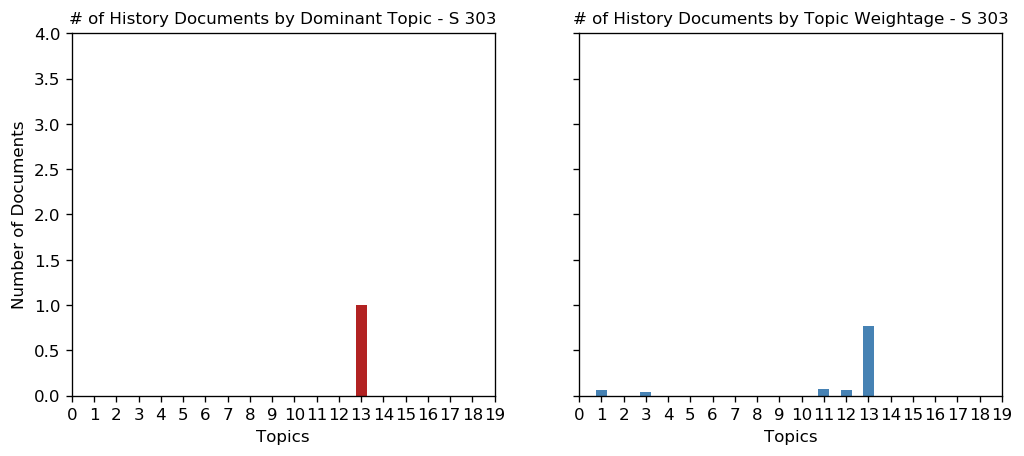

In [72]:
# Plot for subject 303 comparing document topics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_303, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents by Dominant Topic - S 303', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 4)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_303, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('# of History Documents by Topic Weightage - S 303', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [73]:
#select only for subject 99868 that has attempted suicide
documents_99868 = icd9_suicide_notes.loc[icd9_suicide_notes['SUBJECT_ID'] == 99868]

In [74]:
documents_99868

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME,text_processed,history,WO_Headers,index
42491,99868,E9500,Discharge summary,Admission Date: [**2142-9-7**] D...,2142-09-07 05:36:00,admission date discharge date date of bi...,yo f with hx of depression w si on effexor n...,yo f with hx of depression w si on effexor n...,651


In [75]:
#resetting index 
documents_99868 = documents_99868.reset_index()

In [76]:
#use preprocess function on suicide attempt subjects
processed_docs_99868 = documents_99868['text_processed'].map(preprocess)

In [77]:
#create dictionary of words
dictionary_99868s = gensim.corpora.Dictionary(processed_docs_99868)

In [78]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_99868s = [dictionary_99868s.doc2bow(doc) for doc in processed_docs_99868]

In [79]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_99868, topic_percentages_99868 = topics_per_document(lda_model, bow_corpus_99868s)            

# Distribution of Dominant Topics in Each Document
df_99868 = pd.DataFrame(dominant_topics_99868, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_99868 = df_99868.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_99868 = dominant_topic_in_each_doc_99868.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_99868 = pd.DataFrame([dict(t) for t in topic_percentages_99868])
df_topic_weightage_by_doc_99868 = topic_weightage_by_doc_99868.sum().to_frame(name='count').reset_index()

In [80]:
df_topic_sents_keywords_99868 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_99868s, texts=processed_docs_99868)

# Format
df_dominant_topic_99868 = df_topic_sents_keywords_99868.reset_index()
df_dominant_topic_99868.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_99868.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.513,"blood, bleed, hct, unit, recent, hypertens, re...","[admiss, date, discharg, date, date, birth, se..."


In [81]:
suicide_text = icd9_suicide_notes[['WO_Headers']]
suicide_text

,WO_Headers
9,pt is f h o schizophrenia admitted for clozap...
22,the patient is a year old female with a hist...
42,this year old male was an unrestrained drive...
44,year old male transferred from hospital1 fo...
102,this is a year old male with history of hype...
...,...
42449,pt is a year old male with no pmh presents w...
42450,n firstname unit no numeric identifier admiss...
42488,hpi yom with possible intoxication today poss...
42491,yo f with hx of depression w si on effexor n...


In [82]:
suicide_text = suicide_text.drop_duplicates()

In [83]:
suicide_text = suicide_text.reset_index()

In [84]:
#use preprocess function on entire documents for suicide attempt
s_proc_docs = suicide_text['WO_Headers'].map(preprocess)

In [85]:
#create dictionary of words and number of appearances 
s_dictionary = gensim.corpora.Dictionary(s_proc_docs)

In [86]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
s_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [87]:
#go through each document and report words and occurrences using doc2box for token id and amount
s_bow_corpus = [s_dictionary.doc2bow(doc) for doc in s_proc_docs]

In [88]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
s_tfidf = models.TfidfModel(s_bow_corpus)
s_corpus_tfidf = s_tfidf[s_bow_corpus]

In [89]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_s, topic_percentages_s = topics_per_document(lda_model, s_bow_corpus)            

# Distribution of Dominant Topics in Each Document
df_s = pd.DataFrame(dominant_topics_s, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_s = df_s.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_s = dominant_topic_in_each_doc_s.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_s = pd.DataFrame([dict(t) for t in topic_percentages_s])
df_topic_weightage_by_doc_s = topic_weightage_by_doc_s.sum().to_frame(name='count').reset_index()

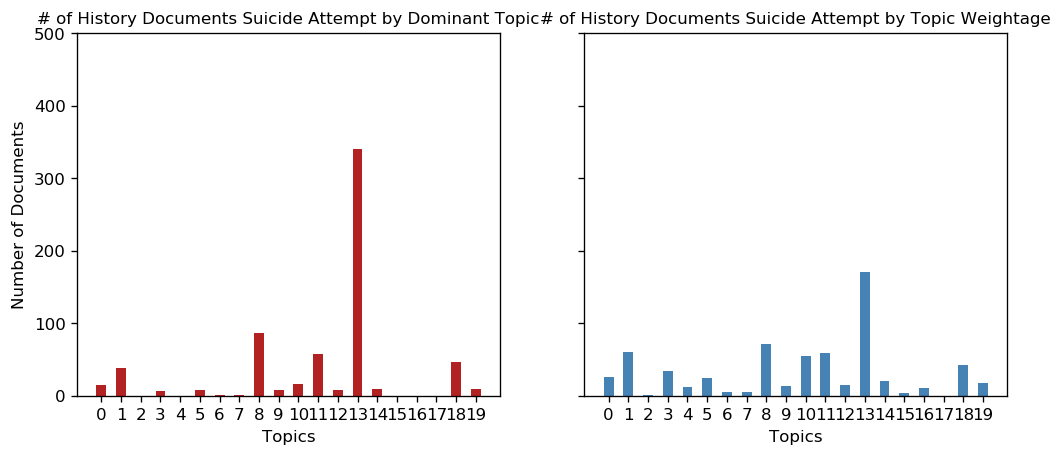

In [90]:
# Plot for comparing document topics from suicide attempts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_s, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents Suicide Attempt by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 500)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_s, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('# of History Documents Suicide Attempt by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [91]:
df_topic_sents_keywords_s = format_topics_sentences(ldamodel=lda_model, corpus=s_bow_corpus, texts=s_proc_docs)

# Format
df_dominant_topic_s = df_topic_sents_keywords_s.reset_index()
df_dominant_topic_s.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_s.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.7971,"blood, bleed, hct, unit, recent, hypertens, re...","[schizophrenia, admit, clozapin, overdos, repo..."
1,1,13.0,0.7240,"blood, bleed, hct, unit, recent, hypertens, re...","[patient, year, old, femal, histori, hypertens..."
2,2,13.0,0.5967,"blood, bleed, hct, unit, recent, hypertens, re...","[year, old, male, unrestrain, driver, motor, v..."
3,3,13.0,0.5867,"blood, bleed, hct, unit, recent, hypertens, re...","[year, old, male, transfer, hospit, liver, tra..."
4,4,13.0,0.4416,"blood, bleed, hct, unit, recent, hypertens, re...","[year, old, male, histori, hypertens, osteomye..."
5,5,13.0,0.5711,"blood, bleed, hct, unit, recent, hypertens, re...","[year, old, woman, histori, seizur, present, l..."
6,6,10.0,0.2250,"tablet, sig, daili, discharg, medic, time, blo...","[depress, suicid, ideat, present, osh, famili,..."
7,7,10.0,0.3786,"tablet, sig, daili, discharg, medic, time, blo...","[know, lastnam, year, old, femal, aortobifemor..."
8,8,13.0,0.3767,"blood, bleed, hct, unit, recent, hypertens, re...","[patient, year, old, femal, histori, depress, ..."
9,9,13.0,0.4100,"blood, bleed, hct, unit, recent, hypertens, re...","[patient, year, old, femal, undergo, fall, app..."


In [92]:
#what is the min and max probability for matching a topic?
df_dominant_topic_s['Topic_Perc_Contrib'].describe()

count    653.000000
mean       0.335029
std        0.099841
min        0.127800
25%        0.264400
50%        0.320600
75%        0.387200
max        0.797100
Name: Topic_Perc_Contrib, dtype: float64

In [93]:
df_dominant_topic_s.groupby('Dominant_Topic').size()

Dominant_Topic
0.0      17
1.0      39
3.0       7
4.0       1
5.0       8
6.0       1
8.0      86
9.0       8
10.0     16
11.0     58
12.0      8
13.0    338
14.0      9
18.0     48
19.0      9
dtype: int64

In [95]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_stf, topic_percentages_stf = topics_per_document(lda_model_tf, s_corpus_tfidf)            

# Distribution of Dominant Topics in Each Document
df_stf = pd.DataFrame(dominant_topics_stf, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_stf = df_stf.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_stf = dominant_topic_in_each_doc_stf.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_stf = pd.DataFrame([dict(t) for t in topic_percentages_stf])
df_topic_weightage_by_doc_stf = topic_weightage_by_doc_stf.sum().to_frame(name='count').reset_index()

In [97]:
#what other topics have higher probabilities?
df_topic_weightage_by_doc_stf

,index,count
0,11,545.759611
1,10,11.380967
2,13,0.653055
3,0,1.216051
4,9,8.710710
5,8,0.512765
6,1,0.978719
7,6,5.949273
8,18,1.986534
9,17,0.580263


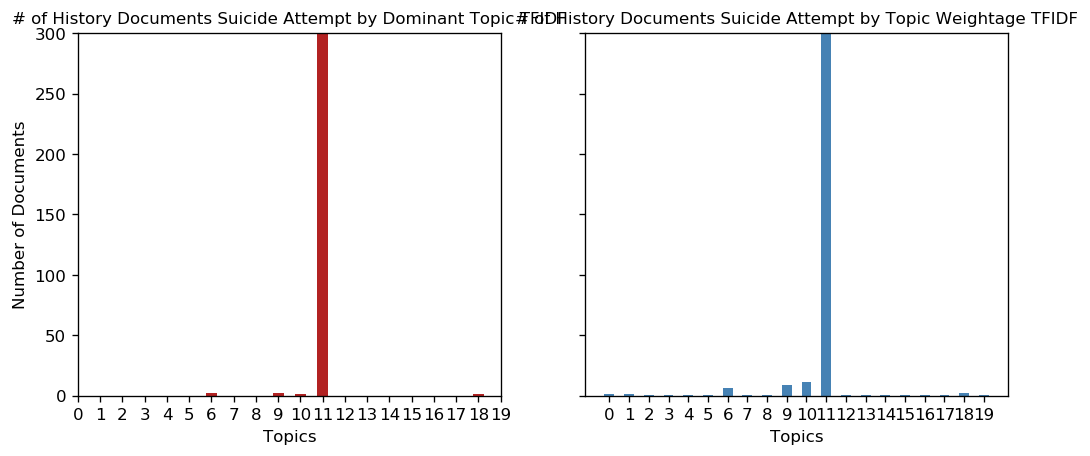

In [98]:
# Plot for comparing document topics from suicide attempts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_stf, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents Suicide Attempt by Dominant Topic TFIDF', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 300)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_stf, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('# of History Documents Suicide Attempt by Topic Weightage TFIDF', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [99]:
df_topic_sents_keywords_stf = format_topics_sentences(ldamodel=lda_model_tf, corpus=s_corpus_tfidf, texts=s_proc_docs)

# Format
df_dominant_topic_stf = df_topic_sents_keywords_stf.reset_index()
df_dominant_topic_stf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_stf.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.8728,"cancer, right, leav, chest, abdomin, report, n...","[schizophrenia, admit, clozapin, overdos, repo..."
1,1,11.0,0.8659,"cancer, right, leav, chest, abdomin, report, n...","[patient, year, old, femal, histori, hypertens..."
2,2,11.0,0.8352,"cancer, right, leav, chest, abdomin, report, n...","[year, old, male, unrestrain, driver, motor, v..."
3,3,11.0,0.8753,"cancer, right, leav, chest, abdomin, report, n...","[year, old, male, transfer, hospit, liver, tra..."
4,4,11.0,0.9050,"cancer, right, leav, chest, abdomin, report, n...","[year, old, male, histori, hypertens, osteomye..."
5,5,11.0,0.8575,"cancer, right, leav, chest, abdomin, report, n...","[year, old, woman, histori, seizur, present, l..."
6,6,11.0,0.8868,"cancer, right, leav, chest, abdomin, report, n...","[depress, suicid, ideat, present, osh, famili,..."
7,7,11.0,0.6650,"cancer, right, leav, chest, abdomin, report, n...","[know, lastnam, year, old, femal, aortobifemor..."
8,8,11.0,0.7261,"cancer, right, leav, chest, abdomin, report, n...","[patient, year, old, femal, histori, depress, ..."
9,9,11.0,0.7146,"cancer, right, leav, chest, abdomin, report, n...","[patient, year, old, femal, undergo, fall, app..."


In [100]:
#what is the min and max probability for matching a topic? TFIDF
df_dominant_topic_stf['Topic_Perc_Contrib'].describe()

count    653.000000
mean       0.839891
std        0.078489
min        0.307800
25%        0.818400
50%        0.864200
75%        0.890200
max        0.925200
Name: Topic_Perc_Contrib, dtype: float64

In [101]:
df_dominant_topic_stf.groupby('Dominant_Topic').size()

Dominant_Topic
6.0       2
9.0       2
10.0      1
11.0    647
18.0      1
dtype: int64

Results so far:
Topic 13 is the dominant topic for suicide attempt groups.
Topic 13's top weighted words include: (13, '0.018*"blood" + 0.016*"bleed" + 0.014*"hct" + 0.013*"unit" + 0.009*"recent" ''+ 0.009*"hypertens" + 0.008*"report" + 0.008*"stool" + 0.008*"episod" + ''0.007*"transfus"') - it appears that most of our patients have a history of receiving blood, high blood pressure, transfusions, etc.

Suicide Attempt group when using only BOW LDA model, has a max of 79% and min of 13%, with and average probability of matching the LDA topics as 34%. This group also has at least 1 document falling under 15/20 topics. Out of these 15 topics, 13, 8, 18, and 0 have the greatest amount of documents falling under those documents. 
Topic 13 was already described above. Out of the total documents assessed (653), Topic 13 matches 52%.
Topic 8 describes symptoms such as nausea, cough and diarrhea. It is unknown in this circumstance what the diagnosis of those symptoms are. Maybe these subjects are more likely to get sick with the flu, or could be this be symptoms of drug and alcohol withdrawl? 13% of the documents match this topic.
Topic 18 describes cancer, ETOH (ethynol alcohol found in beers and other alcoholic drinks), smoking, surgeries, use, ago etc. It seems this topic is talking about cancer and substance abuse. Whether or not they abused and how long ago they may have quit. 7% of the documents match this topic.
Lastly, topic 0 describes chronic, recent, COPD, transfers and rehab. 2% of the documents match this topic.

Additionally, instead of looking at the dominant topics found among groups, we can analyze the topics based on topics with the highest cummulative weight.

TFIDF Results: 
Suicide attempt dominant documents only comes back as having topic 11 the top, with 99% of the documents mathcing. Topic 11 describes cancer, abdomin, notes, etc. It is hard to determine what the general idea behind this topic is. 
(11, '0.002*"cancer" + 0.002*"right" + 0.002*"leav" + 0.002*"chest" + ''0.002*"abdomin" + 0.002*"report" + 0.002*"note" + 0.002*"recent" + ''0.002*"show" + 0.002*"give"').
When looking at cummulative probabilites, topic 11 receives nearly the entire sum, but two other topics do have some probabilities amoung the documents, which is topic 9 and 6, both are describing seizures. Topic 6 has words like stroke, Middle cerebral artery Stroke. And topic 9 includes words like abuse, drink, sedation, disordly etc. Both of which could be useful for identifying high risk subjects.

Analysis of diabetes has to corrected for the error and will be discussed at later time